In [305]:
"""
DEPENDECIES
– Python version: 3.11.2
– Pandas version: 2.2.1
– Numpy version: 1.26.4
– Yahoo Finance version: 0.2.44
– Scipy version: 1.12.0
– Matplotlib version: 3.8.3
"""

import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt

In [295]:
start_date = "2013-12-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

# Download data
nvo_data = yf.download("NVO", start=start_date, end=end_date, interval="1mo") # Novo Nordisk
lly_data = yf.download("LLY", start=start_date, end=end_date, interval="1mo") # Eli Lilly
market_data = yf.download("^GSPC", start=start_date, end=end_date, interval="1mo") # S&P 500
risk_free_data = yf.download("^TNX", start=start_date, end=end_date, interval="1d") # 10-years Treasury Notes

# Adjust returns of 10-years Treasury Notes
risk_free_data = risk_free_data.resample('MS').first()
risk_free_data["Close"] = risk_free_data["Close"] / 100

# Calculate returns
nvo_data["Return"] = nvo_data["Close"].pct_change()
lly_data["Return"] = lly_data["Close"].pct_change()
market_data["Return"] = market_data["Close"].pct_change()

# Drop data: 
nvo_data = nvo_data.iloc[1:]
lly_data = lly_data.iloc[1:]
market_data = market_data.iloc[1:]
risk_free_data = risk_free_data.iloc[1:]

# Change Y-m-d date to Y-m date
nvo_data.index = nvo_data.index.strftime("%Y-%m")
lly_data.index = lly_data.index.strftime("%Y-%m")
market_data.index = market_data.index.strftime("%Y-%m")
risk_free_data.index = risk_free_data.index.strftime("%Y-%m")

# Novo Nordisk & Eli Lilly datasets creation
nvo_data = nvo_data[["Return", "Close"]]
nvo_data["Market return"] = market_data["Return"]
nvo_data["Risk-free return"] = risk_free_data["Close"]
nvo_data["Excess return"] = nvo_data["Return"] - nvo_data["Risk-free return"]
nvo_data["Excess market return"] = nvo_data["Market return"] - nvo_data["Risk-free return"]

lly_data = lly_data[["Return", "Close"]]
lly_data["Market return"] = market_data["Return"]
lly_data["Risk-free return"] = risk_free_data["Close"]
lly_data["Excess return"] = lly_data["Return"] - lly_data["Risk-free return"]
lly_data["Excess market return"] = lly_data["Market return"] - lly_data["Risk-free return"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [355]:
#######################################################
# Expected returns modelling via CAPM
#######################################################

# Market Beta calculation
nvo_linearregress = stats.linregress(nvo_data["Excess market return"], nvo_data["Excess return"])
lly_linearregress = stats.linregress(lly_data["Excess market return"], lly_data["Excess return"])
nvo_beta = nvo_linearregress.slope
lly_beta = lly_linearregress.slope

# Market and stocks (NVO & LLY) returns
market_return = (market_data["Close"][-1] - market_data["Close"][0]) / market_data["Close"][0]
nvo_return = (nvo_data["Close"][-1] - nvo_data["Close"][0]) / nvo_data["Close"][0]
lly_return = (lly_data["Close"][-1] - lly_data["Close"][0]) / lly_data["Close"][0]
risk_free_return = nvo_data["Risk-free return"][-1]

# CAPM : E[R] = Rf + B * (Rm - Rf])
nvo_exp_return = nvo_data["Risk-free return"][-1] + nvo_beta * (market_return - nvo_data["Risk-free return"][-1])
lly_exp_return = nvo_data["Risk-free return"][-1] + lly_beta * (market_return - lly_data["Risk-free return"][-1])

/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_60243/1635827832.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  market_return = (market_data["Close"][-1] - market_data["Close"][0]) / market_data["Close"][0]
/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_60243/1635827832.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nvo_return = (nvo_data["Close"][-1] - nvo_data["Close"][0]) / nvo_data["Close"][0]
/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_60243/1635827832.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer 

In [407]:
nvo_exp_return

1.1086593167144374

/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_60243/3340500747.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['', '0%', '200%', '400%', '600%', '800%', '1 000%', '1 200%', '1 400%', '1 600%'])


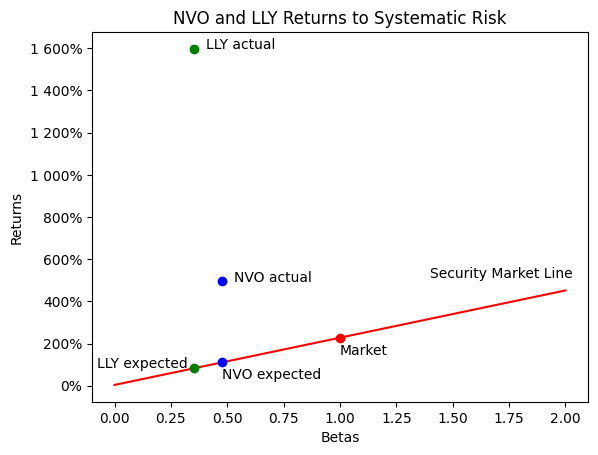

In [397]:
# ACTUAL & EXPECTED RETURNS PLOT
betas = [x/10 for x in range(21)]
assetReturns = [risk_free_return+(market_return-risk_free_return)*x for x in betas]

plt.plot(1, market_return, "ro") # Market return 
plt.plot(betas, assetReturns, color="red")
plt.annotate("Market", xy=(1, market_return + 0.01), xytext=(1, market_return - 0.8))
plt.text(1.4, 5.1, "Security Market Line")

plt.plot(nvo_beta, nvo_return, "bo")
plt.annotate("NVO actual", xy=(nvo_beta, nvo_return + 0.01), xytext=(nvo_beta + 0.05, nvo_return))
plt.plot(nvo_beta, nvo_exp_return, "bo")
plt.annotate("NVO expected", xy=(nvo_beta, nvo_exp_return), xytext=(nvo_beta, nvo_exp_return - 0.8))

plt.plot(lly_beta, lly_return, "go")
plt.annotate("LLY actual", xy=(lly_beta, lly_return + 0.01), xytext=(lly_beta + 0.05, lly_return))
plt.plot(lly_beta, lly_exp_return, "go")
plt.annotate("LLY expected", xy=(lly_beta, lly_exp_return), xytext=(lly_beta - 0.43, lly_exp_return))

plt.gca().set_yticklabels(['', '0%', '200%', '400%', '600%', '800%', '1 000%', '1 200%', '1 400%', '1 600%'])

plt.title("NVO and LLY Returns to Systematic Risk")
plt.xlabel("Betas")
plt.ylabel("Returns")

plt.show()

In [399]:
# Calculate sample statistics
mean = np.mean(nvo_data["Excess return"])
std_dev = np.std(nvo_data["Excess return"], ddof=1)  # Sample standard deviation
n = len(nvo_data["Excess return"])

# 95% confidence interval calculation
confidence = 0.95
z = stats.norm.ppf((1 + confidence) / 2)  # z-score for 95% CI (1.96)

# Calculate margin of error
margin_of_error = z * (std_dev / np.sqrt(n))

# Confidence interval
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error

In [403]:
# 95% Confidential boundaries of monthly returns
def calculateCI(data):
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)

    confidence = 0.95
    z = stats.norm.ppf((1 + confidence) / 2)

    margin_of_error = z * (std_dev / np.sqrt(n))

    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    
    return lower_bound, upper_bound

print(calculateCI(nvo_data["Excess return"]))
print(calculateCI(lly_data["Excess return"]))


(-0.018998413496499757, 0.003269262326125774)
(-0.01151777572885661, 0.012600362469689484)
